# Fraud Detection

## Import required modules

In [1]:
get_ipython().magic(u'matplotlib inline')
from __future__ import division
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from operator import itemgetter
from itertools import groupby
import numpy as np
import pandas as pd
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read and preview data

We read the `data_for_student_case.csv` file and preview the data.

In [2]:
data = pd.read_csv('data/data_for_student_case.csv')
data.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


In [3]:
data.dtypes

txid                              int64
bookingdate                      object
issuercountrycode                object
txvariantcode                    object
bin                             float64
amount                          float64
currencycode                     object
shoppercountrycode               object
shopperinteraction               object
simple_journal                   object
cardverificationcodesupplied     object
cvcresponsecode                   int64
creationdate                     object
accountcode                      object
mail_id                          object
ip_id                            object
card_id                          object
dtype: object

In [4]:
for x in data.columns:
    unique_values = set(data[x])
    if len(unique_values) < 100:
        print x,": ", unique_values


txvariantcode :  set(['visasignature', 'visaplatinum', 'mc', 'visacorporate', 'visagold', 'visaclassic', 'mcdebit', 'electron', 'visa', 'visabusiness', 'visadebit', 'visapurchasing', 'vpay', 'mccredit', 'cirrus'])
currencycode :  set(['MXN', 'SEK', 'AUD', 'GBP', 'NZD'])
shopperinteraction :  set(['ContAuth', 'Ecommerce', 'POS'])
simple_journal :  set(['Refused', 'Settled', 'Chargeback'])
cardverificationcodesupplied :  set([False, True, nan])
cvcresponsecode :  set([0, 1, 2, 3, 5])
accountcode :  set(['UKAccount', 'APACAccount', 'SwedenAccount', 'MexicoAccount'])


In [5]:
data.describe() #the only relevant desciption is the amount attribute

,txid,bin,amount,cvcresponsecode
count,290382.000000,290242.000000,2.903820e+05,290382.000000
mean,279916.750673,485254.586238,2.936462e+04,0.769004
std,138437.214796,37015.528140,6.829927e+04,0.508933
min,1.000000,400000.000000,5.000000e+01,0.000000
25%,218232.250000,462239.000000,4.400000e+03,0.000000
50%,304071.500000,475139.000000,7.095000e+03,1.000000
75%,387592.750000,518652.000000,1.589500e+04,1.000000
max,482734.000000,676883.000000,2.785840e+06,5.000000


## Preprocessing

Some preprocessing steps that we try to apply are:
* Remove the `refused` transactions, because their fraudulent ambiguity
* Transform creationdate to pandas datetime
* Reduce the possible number of CVC response code (as it is 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked) to 0, 1, and 3
* Map float columns which supposed to be categorical / identifier (`bin` and `cvcresponsecode`)
* Convert to EURO
* Assign fraudulent label based on `simple_journal` attribute (fraudulent = 1 if simple_journal='chargeback', else fraudulent = 0)

### Remove 'refused' transactions

In [6]:
data_preproc = data.loc[data['simple_journal'] != 'Refused'].copy()
data_preproc.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


### Transform date to pandas datetime

In [7]:
data_preproc['creationdate'] = pd.to_datetime(data_preproc['creationdate'])
# save month, date, and weekday
data_preproc['creation_month'] = data_preproc.creationdate.dt.month
data_preproc['creation_weekday'] = data_preproc.creationdate.dt.weekday
data_preproc['creation_day'] = data_preproc.creationdate.dt.day

# don't need to process booking date, will be removed anyway:
# data_preproc['bookingdate'] = pd.to_datetime(data_preproc['bookingdate'])
# convert datetime to timestamp
# data_preproc['ts'] = data_preproc.creationdate.values.astype(np.int64) // 10 ** 9
# print (data_preproc)

### Map cvcresponsecode with value 3-6 to 3

In [8]:
data_preproc['cvcresponsecode'] = map(lambda x: 3 if int(x) >= 3 else int(x), data_preproc['cvcresponsecode'])

### Map to categorical and object (for identifier) datatype

In [9]:
data_preproc['bin'] = data_preproc['bin'].astype(int)
data_preproc['bin'] = data_preproc['bin'].astype(str)
data_preproc['txid'] = data_preproc['txid'].astype(str)
for category_column in ["issuercountrycode","txvariantcode", "bin", "currencycode","shopperinteraction","simple_journal","cardverificationcodesupplied","cvcresponsecode","accountcode"]:  
    data_preproc[category_column] = data_preproc[category_column].astype("category")
data_preproc.dtypes

txid                                    object
bookingdate                             object
issuercountrycode                     category
txvariantcode                         category
bin                                   category
amount                                 float64
currencycode                          category
shoppercountrycode                      object
shopperinteraction                    category
simple_journal                        category
cardverificationcodesupplied          category
cvcresponsecode                       category
creationdate                    datetime64[ns]
accountcode                           category
mail_id                                 object
ip_id                                   object
card_id                                 object
creation_month                           int64
creation_weekday                         int64
creation_day                             int64
dtype: object

### Convert amount to EURO currencies

In [10]:
from currency_converter import CurrencyConverter

currency_converter = CurrencyConverter()
data_preproc['amount_euro'] = map(lambda x,y: currency_converter.convert(x,y, 'EUR'), data_preproc['amount'],data_preproc['currencycode'])
data_preproc.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,...,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,creation_month,creation_weekday,creation_day,amount_euro
0,1,2015-11-09 14:26:51,MX,mccredit,530056,64800.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,7,2,1,2809.743914
1,2,2015-11-09 14:27:38,MX,mccredit,547046,44900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,7,3,2,1946.875027
2,3,2015-11-23 16:34:16,MX,mccredit,528843,149900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,7,3,2,6499.700814
3,4,2015-11-23 16:34:51,MX,mccredit,547146,109900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,7,4,3,4765.290991
4,5,2015-11-09 14:26:08,MX,visaclassic,477291,89900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,7,2,8,3898.086079


### Apply fraudulent label

In [11]:
data_preproc['is_fraud'] = data_preproc.apply(lambda x: 1 if x['simple_journal'] == "Chargeback" else 0, axis=1)
# remove the simple_journal column
data_preproc = data_preproc.drop(['simple_journal'],axis=1)
data_preproc.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,...,creationdate,accountcode,mail_id,ip_id,card_id,creation_month,creation_weekday,creation_day,amount_euro,is_fraud
0,1,2015-11-09 14:26:51,MX,mccredit,530056,64800.0,MXN,MX,Ecommerce,True,...,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,7,2,1,2809.743914,1
1,2,2015-11-09 14:27:38,MX,mccredit,547046,44900.0,MXN,MX,Ecommerce,True,...,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,7,3,2,1946.875027,1
2,3,2015-11-23 16:34:16,MX,mccredit,528843,149900.0,MXN,MX,Ecommerce,True,...,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,7,3,2,6499.700814,1
3,4,2015-11-23 16:34:51,MX,mccredit,547146,109900.0,MXN,MX,Ecommerce,True,...,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,7,4,3,4765.290991,1
4,5,2015-11-09 14:26:08,MX,visaclassic,477291,89900.0,MXN,MX,Ecommerce,True,...,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,7,2,8,3898.086079,1


In [12]:
data_preproc['is_fraud'] = data_preproc['is_fraud'].astype("category")
data_preproc.dtypes

txid                                    object
bookingdate                             object
issuercountrycode                     category
txvariantcode                         category
bin                                   category
amount                                 float64
currencycode                          category
shoppercountrycode                      object
shopperinteraction                    category
cardverificationcodesupplied          category
cvcresponsecode                       category
creationdate                    datetime64[ns]
accountcode                           category
mail_id                                 object
ip_id                                   object
card_id                                 object
creation_month                           int64
creation_weekday                         int64
creation_day                             int64
amount_euro                            float64
is_fraud                              category
dtype: object

### Remove bookingdate
Certain bookingdate indicates that the transaction is indeed fraudulent, so we may not use it for training our classifier

In [13]:
data_preproc = data_preproc.drop(['bookingdate'],axis=1)
data_preproc.head()

,txid,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,creation_month,creation_weekday,creation_day,amount_euro,is_fraud
0,1,MX,mccredit,530056,64800.0,MXN,MX,Ecommerce,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,7,2,1,2809.743914,1
1,2,MX,mccredit,547046,44900.0,MXN,MX,Ecommerce,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,7,3,2,1946.875027,1
2,3,MX,mccredit,528843,149900.0,MXN,MX,Ecommerce,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,7,3,2,6499.700814,1
3,4,MX,mccredit,547146,109900.0,MXN,MX,Ecommerce,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,7,4,3,4765.290991,1
4,5,MX,visaclassic,477291,89900.0,MXN,MX,Ecommerce,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,7,2,8,3898.086079,1


## Visualization Task
We try the following visualization:
* Distribution histogram
* Line chart
* Heat map

### Distribution histogram

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


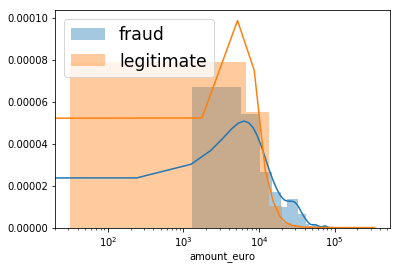

In [14]:
fraud = data_preproc.loc[data_preproc['is_fraud'] == 1]
non_fraud = data_preproc.loc[data_preproc['is_fraud'] == 0]
plt.figure("Amount Distribution (Fraud")
fraud_plot = sns.distplot(fraud['amount_euro'], label="fraud")
fraud_plot.set_xscale('log')
non_fraud_plot = sns.distplot(non_fraud['amount_euro'], label="legitimate")
non_fraud_plot.set_xscale('log')
plt.legend(fontsize="xx-large")
plt.show()

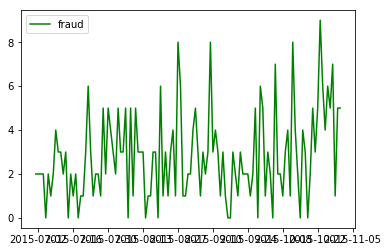

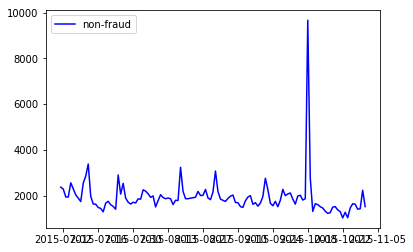

In [15]:
temp_fraud = fraud.set_index('creationdate').resample('1D').count()['txid']
x_fraud = temp_fraud.index
y_fraud = temp_fraud.values

temp_non_fraud = non_fraud.set_index('creationdate').resample('1D').count()['txid']
x_non_fraud = temp_non_fraud.index
y_non_fraud = temp_non_fraud.values


plt.figure()
plt.plot(x_fraud, y_fraud, 'g', label="fraud");
plt.legend()
plt.show()

plt.figure()
plt.plot(x_non_fraud, y_non_fraud,  'b', label="non-fraud");
plt.legend()
plt.show()

### Heat map

We try to plot a heat map in regards of percentage of fraudulent transaction

In [16]:
import itertools

def fraud_heatmap(column_name_a, column_name_b, frac=True):
    # column_name_a = 'currencycode'
    # column_name_b = 'accountcode'

    x_axis = list(data_preproc[column_name_a].unique())
    y_axis = list(data_preproc[column_name_b].unique())
    values = []

    length_x = len(x_axis)
    length_y = len(y_axis)
    x_axis = np.repeat(x_axis, length_y)
    y_axis = y_axis*length_x


    for combination in zip(x_axis, y_axis):
        # number of fraud
        num_fraud = len(fraud.loc[(fraud[column_name_a] == combination[0]) & (fraud[column_name_b] == combination[1])])
        num_total = len(data_preproc.loc[(data_preproc[column_name_a] == combination[0]) & (data_preproc[column_name_b] == combination[1])])
        #num_total = len(data_preproc)
        
        if frac:
            if num_total == 0:
                values.append(0)
            else:
                values.append(num_fraud / float(num_total))
        else: 
            values.append(num_fraud)

    df = pd.DataFrame({column_name_a: x_axis, column_name_b: y_axis, 'value': values })

    # plot it
    df_wide=df.pivot_table( index=column_name_a, columns=column_name_b, values='value' )
    sns.set(rc={"figure.figsize": (10, 10)})
    sns.heatmap( df_wide, cmap="Blues", annot=True)

In [93]:
# select categorical columns
categorical_columns = [x for x in data_preproc.columns if hasattr(data_preproc[x], 'cat') and x != 'issuercountrycode' and x != 'bin']
# remove is_fraud
categorical_columns = categorical_columns[:-1]

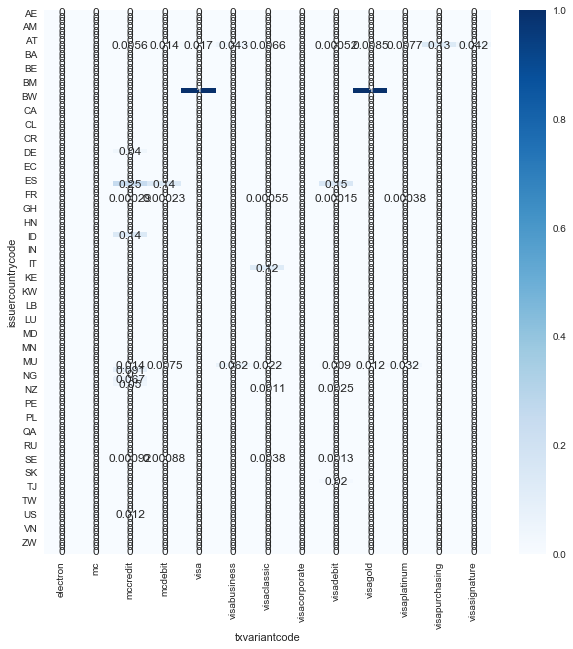

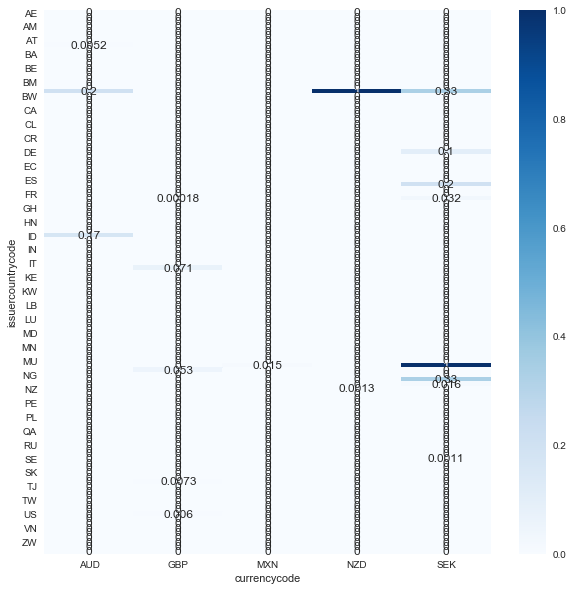

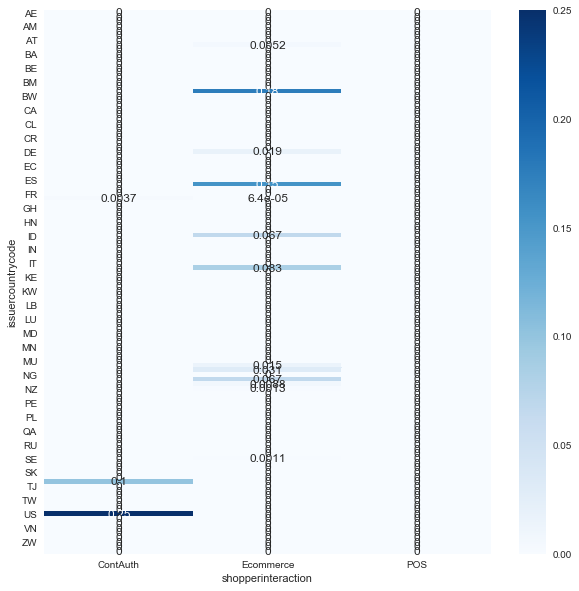

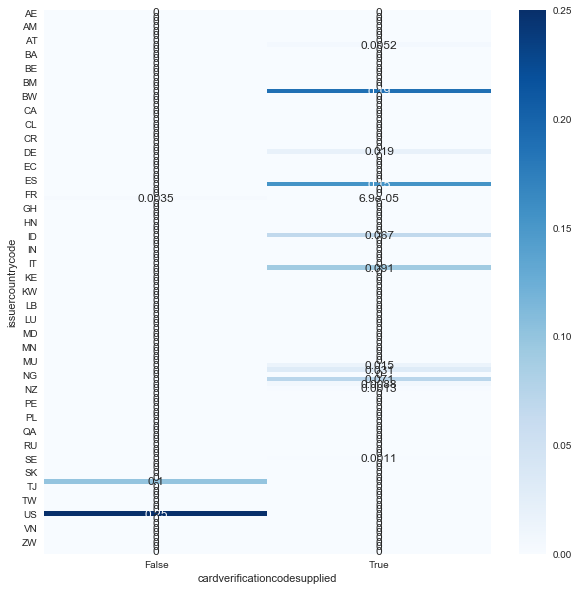

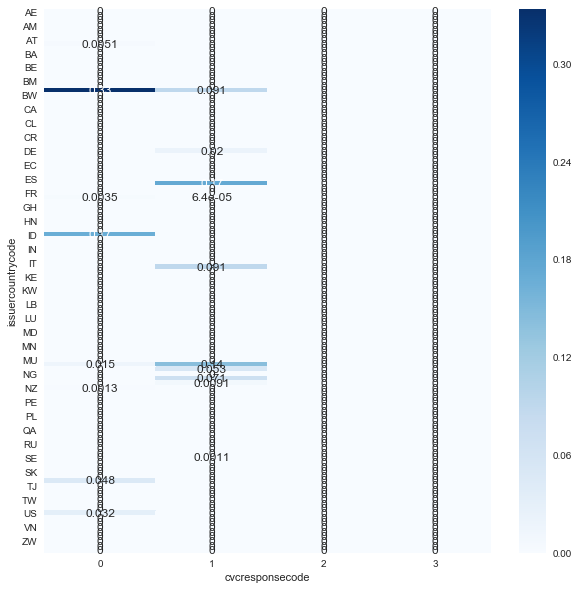

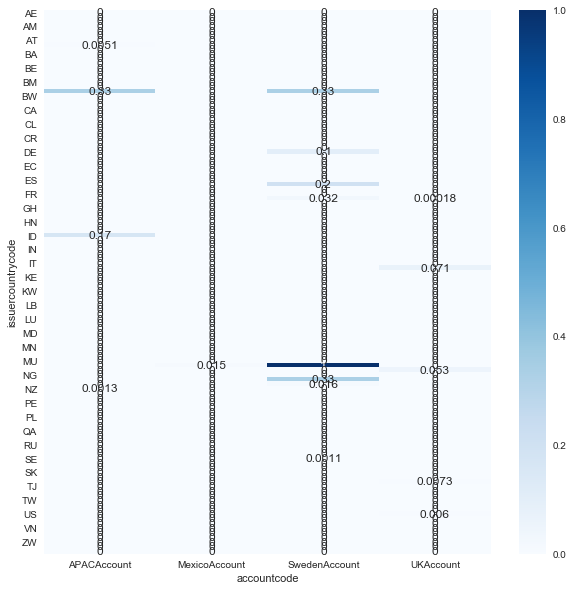

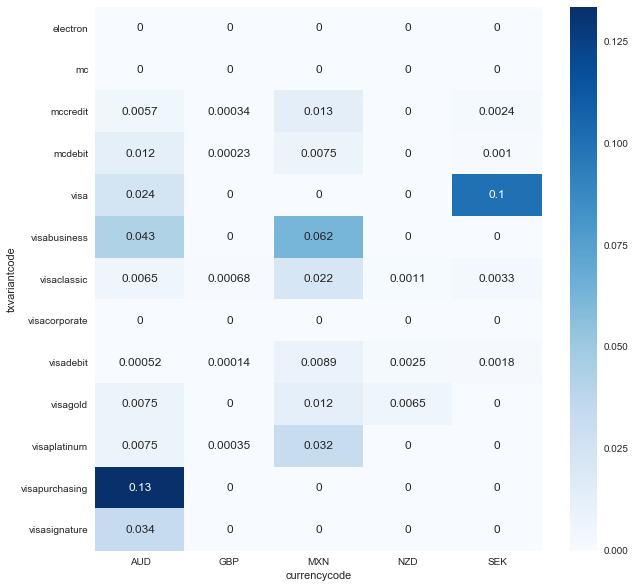

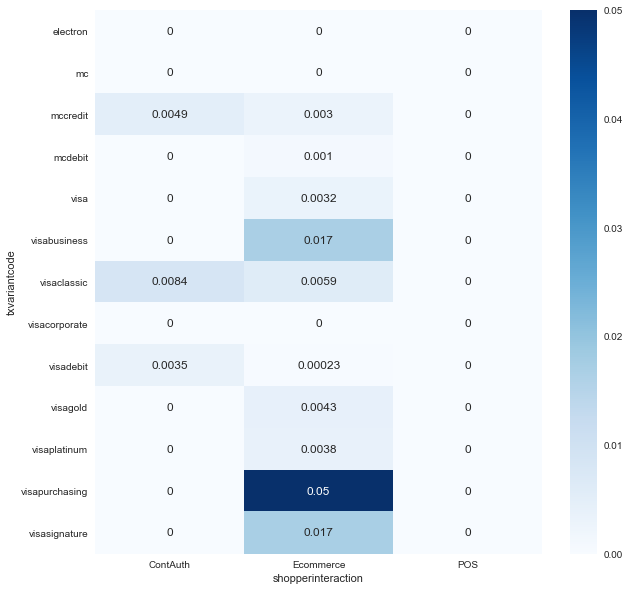

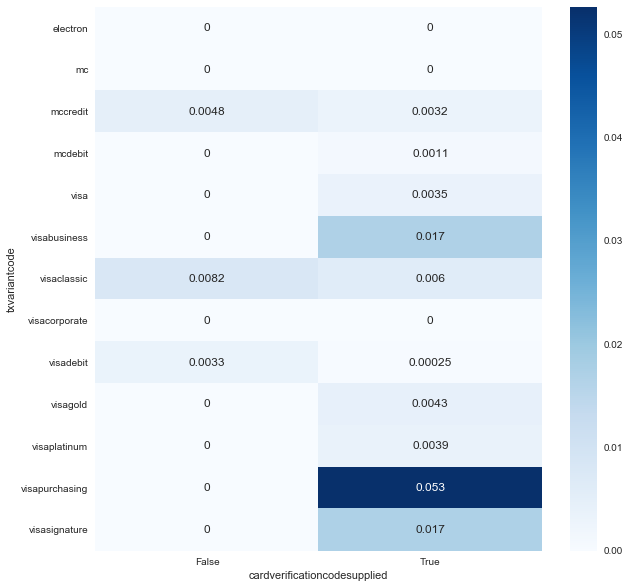

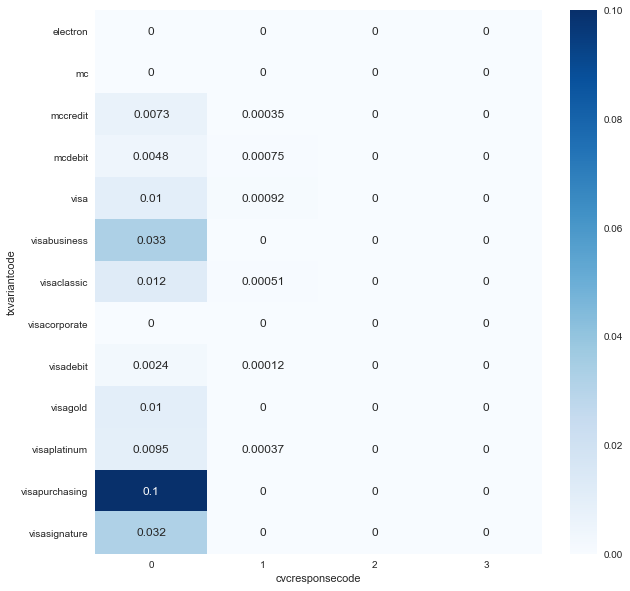

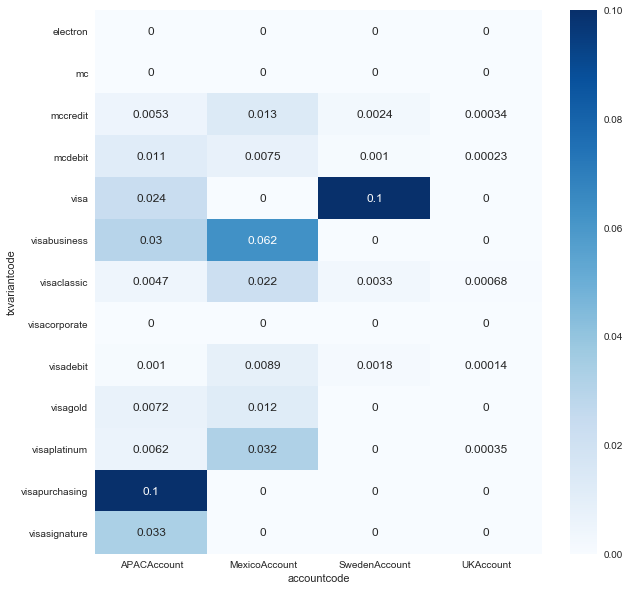

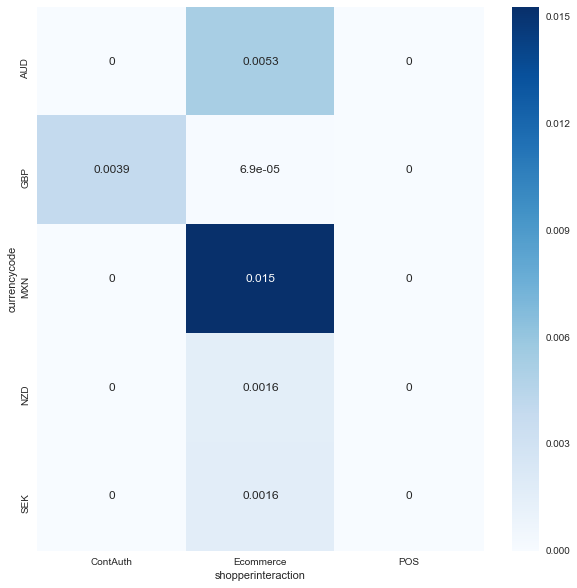

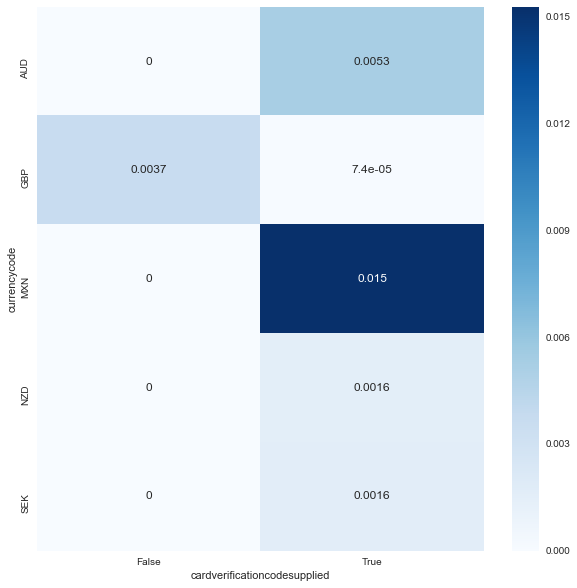

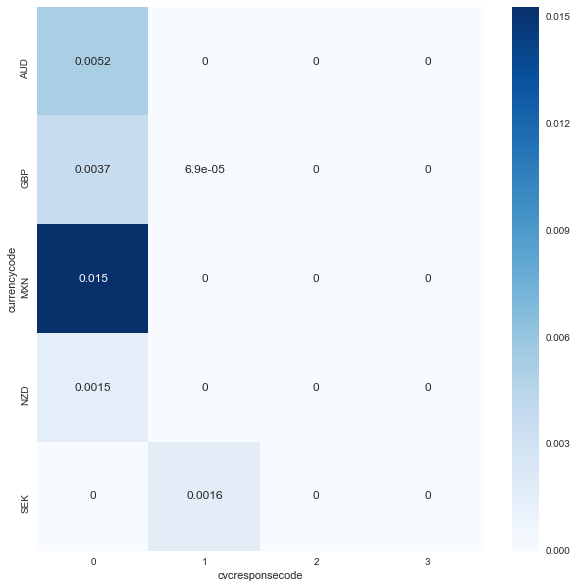

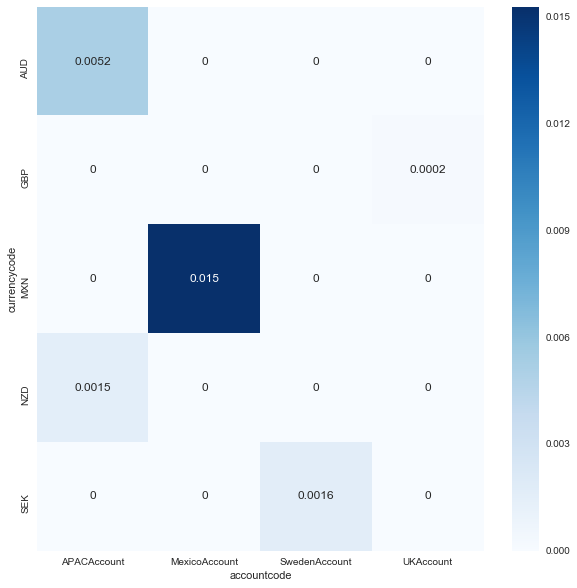

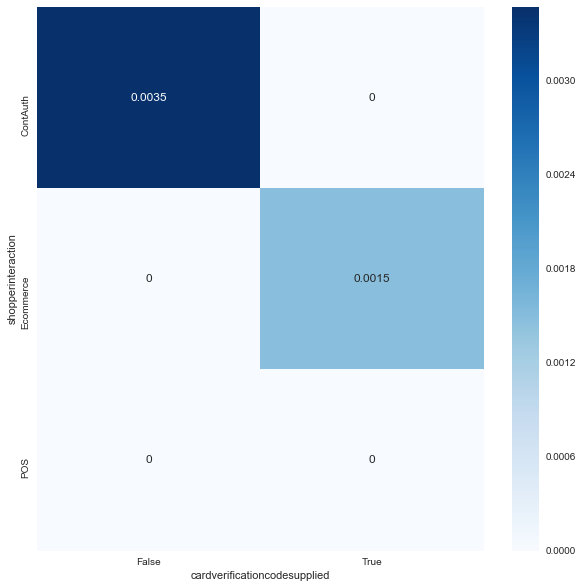

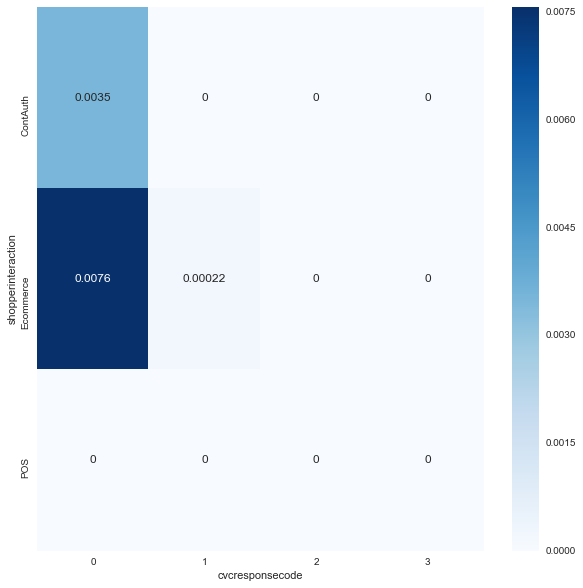

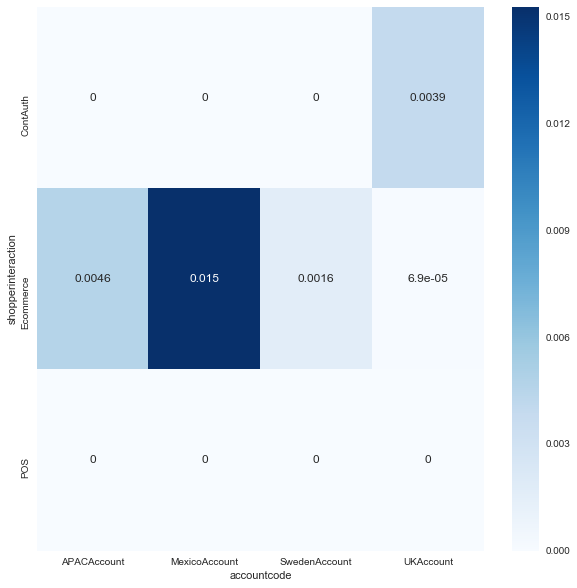

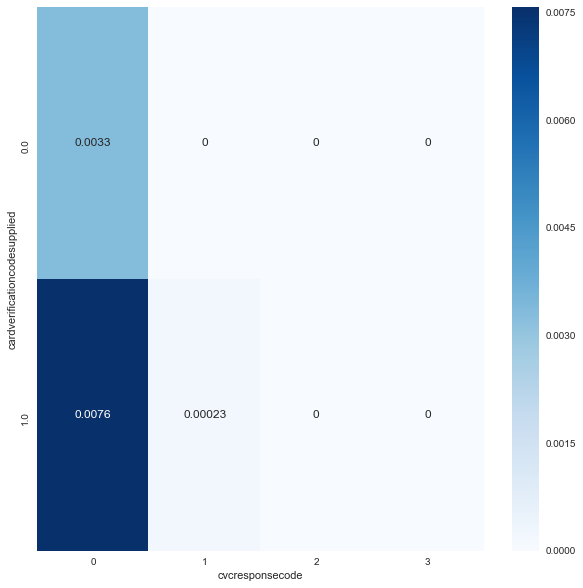

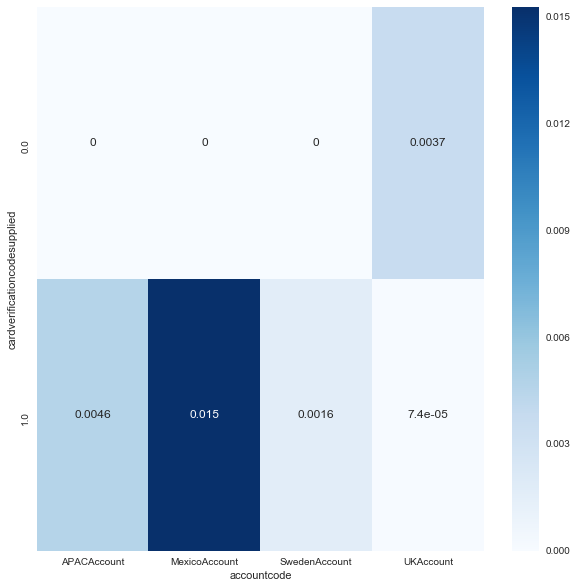

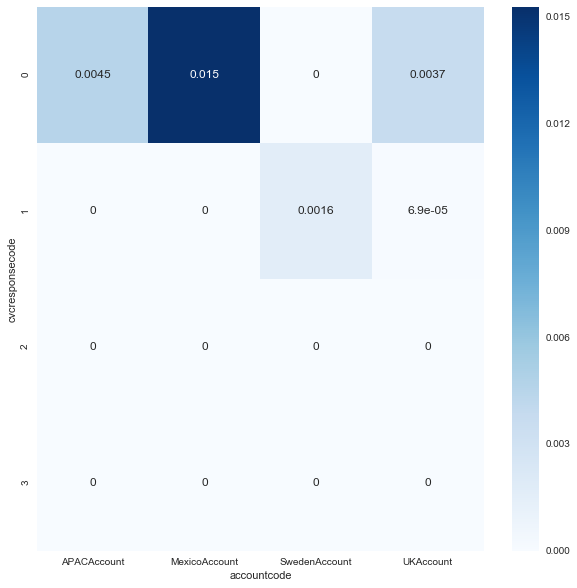

In [94]:
for combination in list(itertools.combinations(categorical_columns,2)):
    fraud_heatmap(combination[0], combination[1], frac=True)
    plt.show()

## Imbalance Task

First let's see how imbalance is the fraud vs non-fraud transactions

In [87]:
data_preproc.is_fraud.value_counts()

0    236691
1       345
Name: is_fraud, dtype: int64

Let's try to do classification without any balancing method. First we need to encode the categorical value:

In [95]:
# remove identifiers
temp = data_preproc.copy()
for x in data_preproc.columns:
    if data_preproc[x].dtypes == np.dtype('O'):
        temp = temp.drop([x], axis=1)
        
temp = temp.drop(['creationdate'], axis=1)
print temp.dtypes

issuercountrycode               category
txvariantcode                   category
bin                             category
amount                           float64
currencycode                    category
shopperinteraction              category
cardverificationcodesupplied    category
cvcresponsecode                 category
accountcode                     category
creation_month                     int64
creation_weekday                   int64
creation_day                       int64
amount_euro                      float64
is_fraud                        category
dtype: object


In [97]:
# remove bin column as it has too many unique values
temp = temp.drop(['bin'], axis=1)
# alternative map bin to few unique values

# for value,count in temp.bin.value_counts().iteritems():
#     if count < 50:
#         temp['bin'].replace(value, 'Other', inplace=True)

# temp['bin'] = temp['bin'].astype("category")
# temp.dtypes
# temp.loc[temp['bin'] == 'Other'].head()

ValueError: labels ['bin'] not contained in axis

In [98]:
# separate labels
labels = temp['is_fraud']
temp = temp.drop(['is_fraud'], axis=1)

temp = pd.get_dummies(temp, dummy_na=True)
temp.head()

feature_names = temp.columns

labels = np.array(labels)
temp = np.array(temp)

len(feature_names)

159

In [99]:
# create train test split
X_train, X_test, y_train, y_test = train_test_split(temp, labels, test_size=0.40, random_state=42)

In [100]:
print "Training Data"
print "Fraud: ", len([x for x in y_train if x == 1])
print "Non-Fraud: ", len([x for x in y_train if x == 0])
    
print "Test Data"
print "Fraud: ", len([x for x in y_test if x == 1])
print "Non-Fraud: ", len([x for x in y_test if x == 0])

Training Data
Fraud:  208
Non-Fraud:  142013
Test Data
Fraud:  137
Non-Fraud:  94678


In [101]:
# loading library
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import recall_score,accuracy_score,f1_score,precision_score

# instantiate learning model
clf = KNeighborsClassifier(n_neighbors=3)

# fitting the model
clf.fit(X_train, y_train)

# predict the response
pred = clf.predict(X_test)

# evaluate performance
print "KNN without SMOTE"
print "Precision: ", precision_score(y_test, pred)
print "Recall: ", recall_score(y_test, pred)
print "F1 Score: ", f1_score(y_test, pred)
print "Accuracy: ", accuracy_score(y_test, pred)

KNN without SMOTE
Precision:  0.17647058823529413
Recall:  0.021897810218978103
F1 Score:  0.03896103896103896
Accuracy:  0.9984390655487001


Ha! Accuracy of **99%** but really low precision and recall >:D Let's try it out with SMOTE

In [111]:
from imblearn.over_sampling import SMOTE

# original_num_non_fraud = len([x for x in y_train if x == 0])
# intended_ratio = 1
# sm = SMOTE(random_state=12, ratio={1:int(intended_ratio * original_num_non_fraud)})
sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

print "Training Data (SMOTE)"
print "Fraud: ", len([x for x in y_train_res if x == 1])
print "Non-Fraud: ", len([x for x in y_train_res if x == 0])

Training Data (SMOTE)
Fraud:  142013
Non-Fraud:  142013


In [104]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train_res, y_train_res)
pred_proba = clf.predict_proba(X_test)[:,1]
pred = clf.predict(X_test)

# evaluate accuracy
print "KNN with SMOTE"
print "Precision: ", precision_score(y_test, pred)
print "Recall: ", recall_score(y_test, pred)
print "F1 Score: ", f1_score(y_test, pred)
print "Accuracy: ", accuracy_score(y_test, pred)

KNN with SMOTE
Precision:  0.010466760961810467
Recall:  0.27007299270072993
F1 Score:  0.02015250544662309
Accuracy:  0.9620524178663713


Improvement of recall!. Let's tune the ratio for the SMOTE

In [106]:
ratio_list = [0.3,0.6,1.0]

for intended_ratio in ratio_list:
    original_num_non_fraud = len([x for x in y_train if x == 0])
    sm = SMOTE(random_state=12, ratio={1:int(intended_ratio * original_num_non_fraud)})
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

    print "Training Data (SMOTE) with Ratio ", intended_ratio
    print "Fraud: ", len([x for x in y_train_res if x == 1])
    print "Non-Fraud: ", len([x for x in y_train_res if x == 0])
    
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train_res, y_train_res)
    pred = clf.predict(X_test)

    print "Precision: ", precision_score(y_test, pred)
    print "Recall: ", recall_score(y_test, pred)
    print "F1 Score: ", f1_score(y_test, pred)
    print "Accuracy: ", accuracy_score(y_test, pred)

Training Data (SMOTE) with Ratio  0.3
Fraud:  42603
Non-Fraud:  142013
Precision:  0.01547842401500938
Recall:  0.24087591240875914
F1 Score:  0.029087703834288228
Accuracy:  0.976765279755313
Training Data (SMOTE) with Ratio  0.6
Fraud:  85207
Non-Fraud:  142013
Precision:  0.012396694214876033
Recall:  0.26277372262773724
F1 Score:  0.02367642222952976
Accuracy:  0.9686863892843959
Training Data (SMOTE) with Ratio  1.0
Fraud:  142013
Non-Fraud:  142013
Precision:  0.010466760961810467
Recall:  0.27007299270072993
F1 Score:  0.02015250544662309
Accuracy:  0.9620524178663713


Let's try to plot the ROC curve.

0.6647636483737502


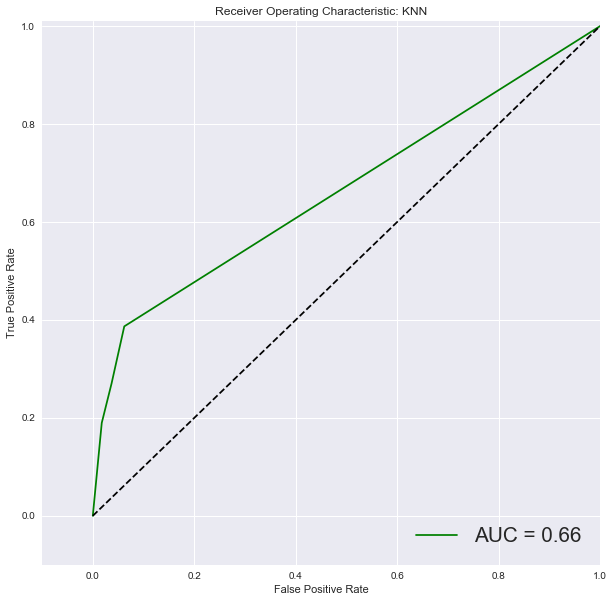

In [107]:
from sklearn.metrics import roc_curve, roc_auc_score
pred_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, pred_proba, pos_label=1)
auc_score = roc_auc_score(y_test, pred_proba)
print auc_score

plt.title('Receiver Operating Characteristic: KNN')

plt.plot(fpr, tpr, 'g',label='AUC = %0.2f'% auc_score)

plt.legend(loc='lower right', fontsize="xx-large")
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
y_test_legit = len(y_test[y_test == 0])
y_test_fraud = len(y_test[y_test == 1])

Now let's try to compare ROC curve with these classifiers: KNN, Logistic Regression, and RandomForest, each without and with SMOTE

In [108]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score, auc, precision_recall_curve


# create classifiers
knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(C=500, penalty='l1')
rf = RandomForestClassifier(n_estimators=100, n_jobs=2)

# create dictionary to store values
clf_dict = {"knn": {"clf": knn}, "lr": {"clf": lr}, "rf": {"clf": rf}}
threshold = 0.8

for k,v in clf_dict.iteritems():
    # train using original dataset
    print k.upper()
    print "Without SMOTE"
    clf = clone(v['clf'])
    clf.fit(X_train, y_train)
    pred_proba = clf.predict_proba(X_test)[:,1]
    pred = clf.predict(X_test)
#     pred = [1 if y >= threshold else 0 for y in pred_proba] # adjust threshold
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba, pos_label=1)
    auc_score = auc(fpr, tpr)
    print "Precision: ", precision_score(y_test, pred)
    print "Recall: ", recall_score(y_test, pred)
    print "F1 Score: ", f1_score(y_test, pred)
    print "AUC: ", auc_score
    precision, recall, _ = precision_recall_curve(y_test, pred_proba)
    v['non-smote'] = {}
    v['non-smote']['fpr'] = fpr
    v['non-smote']['tpr'] = tpr
    v['non-smote']['thresholds'] = thresholds
    v['non-smote']['auc'] = auc_score
    v['non-smote']['recall'] = recall
    v['non-smote']['precision'] = precision
    # train using SMOTE
    print "With SMOTE"
    clf = clone(v['clf'])
    clf.fit(X_train_res, y_train_res)
    pred_proba = clf.predict_proba(X_test)[:,1]
    pred = clf.predict(X_test)
#     pred = [1 if y >= threshold else 0 for y in pred_proba] # adjust threshold
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba, pos_label=1)
    auc_score = auc(fpr, tpr)
    print "Precision: ", precision_score(y_test, pred)
    print "Recall: ", recall_score(y_test, pred)
    print "F1 Score: ", f1_score(y_test, pred)
    print "AUC: ", auc_score
    precision, recall, _ = precision_recall_curve(y_test, pred_proba)
    v['smote'] = {}
    v['smote']['fpr'] = fpr
    v['smote']['tpr'] = tpr
    v['smote']['thresholds'] = thresholds
    v['smote']['auc'] = auc_score
    v['smote']['recall'] = recall
    v['smote']['precision'] = precision
    

KNN
Without SMOTE
Precision:  0.17647058823529413
Recall:  0.021897810218978103
F1 Score:  0.03896103896103896
AUC:  0.5601389141805734
With SMOTE
Precision:  0.010466760961810467
Recall:  0.27007299270072993
F1 Score:  0.02015250544662309
AUC:  0.6647636483737502
RF
Without SMOTE
Precision:  0.08333333333333333
Recall:  0.014598540145985401
F1 Score:  0.024844720496894408
AUC:  0.7479598155438263
With SMOTE
Precision:  0.08695652173913043
Recall:  0.043795620437956206
F1 Score:  0.05825242718446602
AUC:  0.7753599098781687
LR
Without SMOTE
Precision:  0.2857142857142857
Recall:  0.014598540145985401
F1 Score:  0.027777777777777776
AUC:  0.9043918048466388
With SMOTE
Precision:  0.00997163242499785
Recall:  0.8467153284671532
F1 Score:  0.019711129991503824
AUC:  0.8902970082382962


In [109]:
import pickle

## if it's already there
# with open('imbalance_task_result.pickle', 'rb') as handle:
#    clf_dict = pickle.load(handle)

with open('imbalance_task_result.pickle', 'wb') as handle:
    pickle.dump(clf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

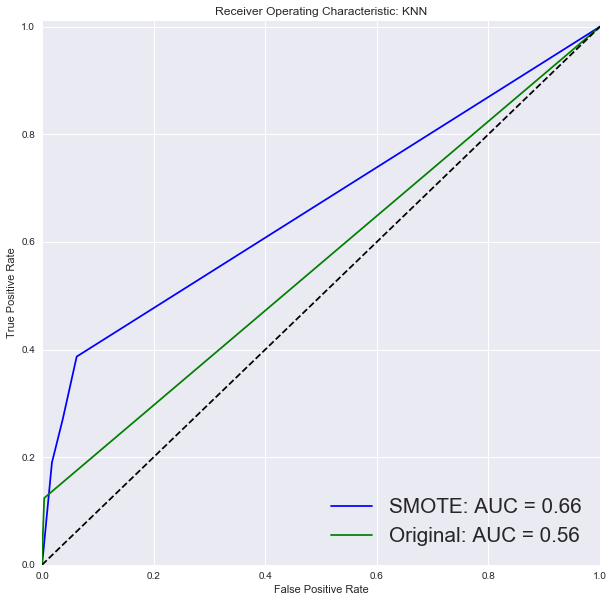

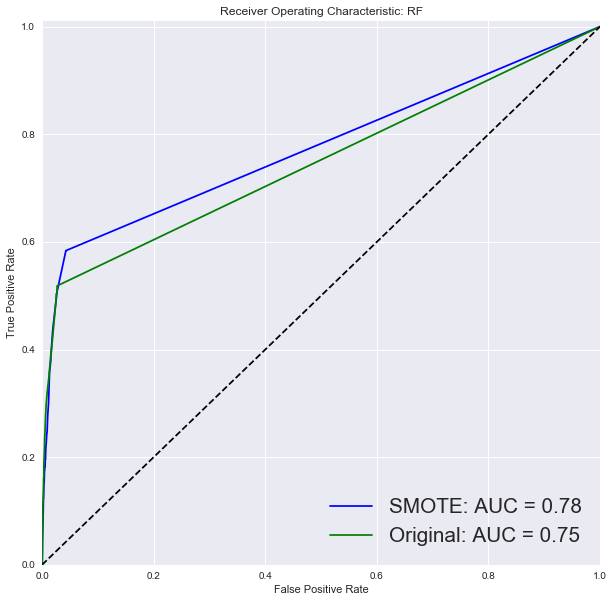

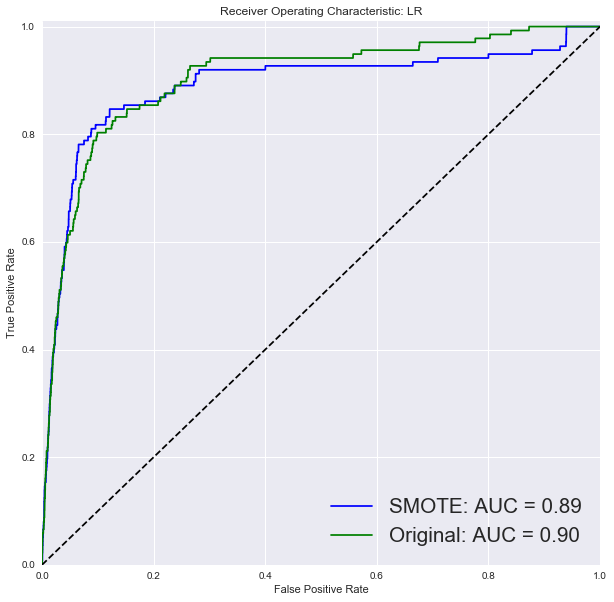

In [110]:
# plot the ROCs
for k in clf_dict.keys():
    plt.title('Receiver Operating Characteristic: ' + k.upper())

    plt.plot(clf_dict[k]['smote']['fpr'], clf_dict[k]['smote']['tpr'], 'b',label='SMOTE: AUC = %0.2f'% clf_dict[k]['smote']['auc'])
    plt.plot(clf_dict[k]['non-smote']['fpr'], clf_dict[k]['non-smote']['tpr'], 'g',label='Original: AUC = %0.2f'% clf_dict[k]['non-smote']['auc'])

    plt.legend(loc='lower right', fontsize="xx-large")
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0,1.0])
    plt.ylim([0,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

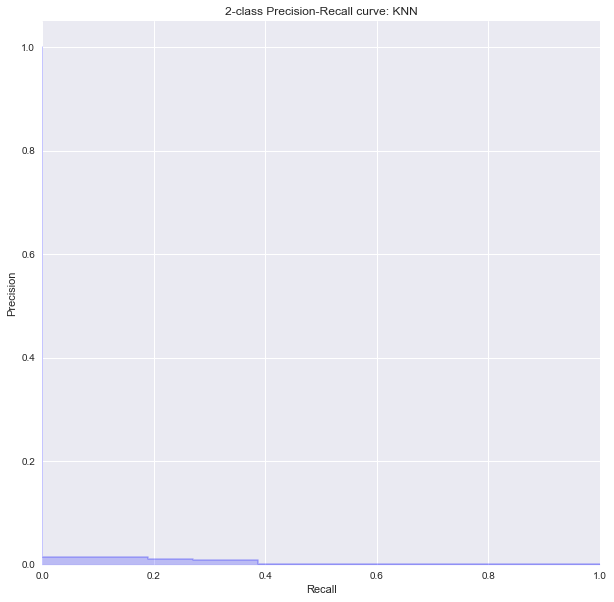

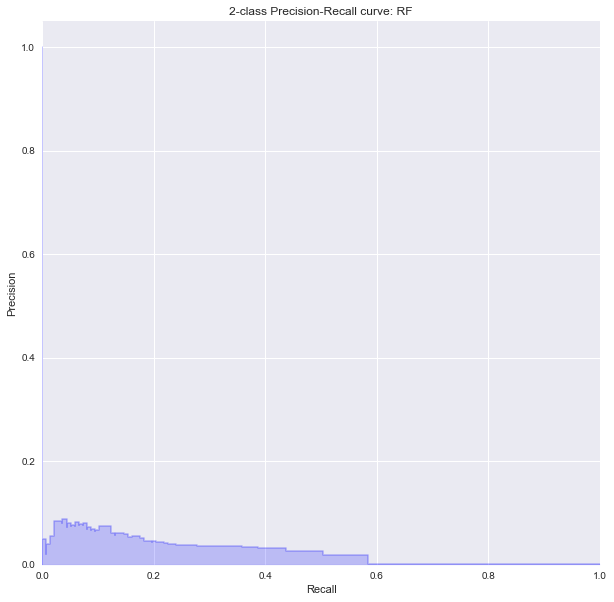

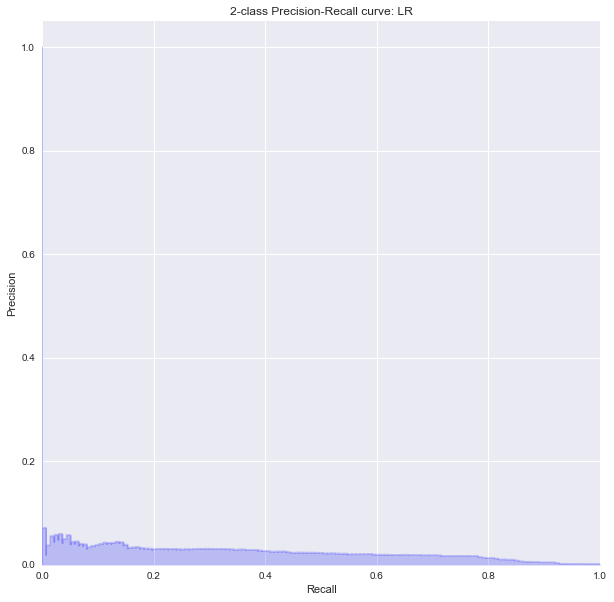

In [112]:
# plot the PR curve
for k in clf_dict.keys():
    plt.step(clf_dict[k]['smote']['recall'], clf_dict[k]['smote']['precision'], color='b', alpha=0.2,
         where='post')
    plt.fill_between(clf_dict[k]['smote']['recall'], clf_dict[k]['smote']['precision'], step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: ' + k.upper())
    plt.show()

## Classification Task

### White-Box: Decision Tree

In [ ]:
# remove identifiers
temp = data_preproc.copy()
for x in data_preproc.columns:
    if data_preproc[x].dtypes == np.dtype('O'):
        temp = temp.drop([x], axis=1)
        
temp = temp.drop(['creationdate'], axis=1)
temp = temp.drop(['bin'], axis=1)
for column in temp.columns:
    if hasattr(temp[column], 'cat'):
        temp[column] = temp[column].cat.codes
        
labels = temp['is_fraud']
temp = temp.drop(['is_fraud'], axis=1)

feature_names = temp.columns

labels = np.array(labels)
temp = np.array(temp)

X_train, X_test, y_train, y_test = train_test_split(temp, labels, test_size=0.33, random_state=42)
# apply SMOTE
sm = SMOTE(ratio=0.9)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)


In [ ]:
from sklearn import tree

modelDT = tree.DecisionTreeClassifier();
modelDT = modelDT.fit(X_train, y_train)
# predict the response
pred = modelDT.predict(X_test)
# evaluate accuracy
recall = recall_score(y_test, pred)
precision = precision_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print ('Precision before smoting - DT', precision) #0.035398230088495575
print ('Recall before smoting - DT', recall) #0.035398230088495575
print ('Accuracy before smoting -  DT', accuracy) #0.9972130602643757

modelDT.fit(X_train_res, y_train_res)
pred = modelDT.predict(X_test)
recalldt_smoting = recall_score(y_test, pred)
precision_smoting = precision_score(y_test, pred)
accuracydt_smoting = accuracy_score(y_test, pred)

print ('Precision after smoting - DT', precision_smoting) #0.035398230088495575
print ('Recall after smoting - DT', recalldt_smoting) #0.05309734513274336
print ('Accuracy after smoting -  DT', accuracydt_smoting) #0.9967911840658639

In [ ]:
#visualization of the 
import graphviz

dot_data = tree.export_graphviz(modelDT, out_file=None, 
                         feature_names=feature_names,  
                         class_names=['Legitimate', 'Fraud'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("decision_tree_fraud")